## Import librairies

In [1]:
%matplotlib inline

from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification, load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from yellowbrick.cluster import InterclusterDistance, SilhouetteVisualizer, KElbowVisualizer


pd.set_option("display.max_columns", None)

## Load the dataset

We will start by loading the digits dataset. This dataset contains handwritten digits from 0 to 9. In the context of clustering, one would like to group images such that the handwritten digits on the image are the same.

In [2]:
digits = load_digits()  # Dimensionality: 64 features

X, labels = digits.data, digits.target
images = digits.images

# column name for 64
column_names = [f"X{i}" for i in range(64)]

data = pd.DataFrame(X, columns=column_names).assign(label=labels)

(n_samples, n_features), n_digits = X.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [3]:
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


## EDA

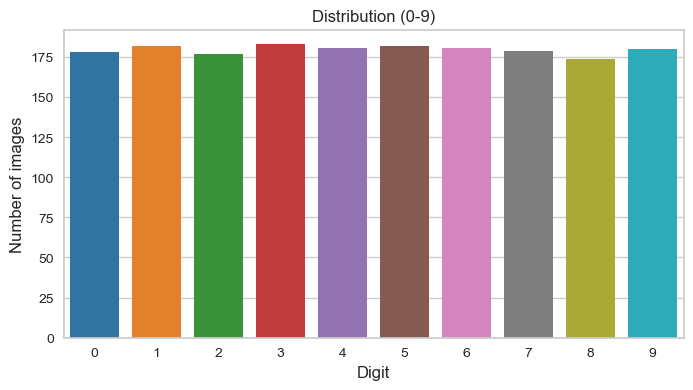

In [3]:
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=data, palette='tab10')

plt.title("Distribution (0-9)")
plt.xlabel("Digit")
plt.ylabel("Number of images")
plt.show()

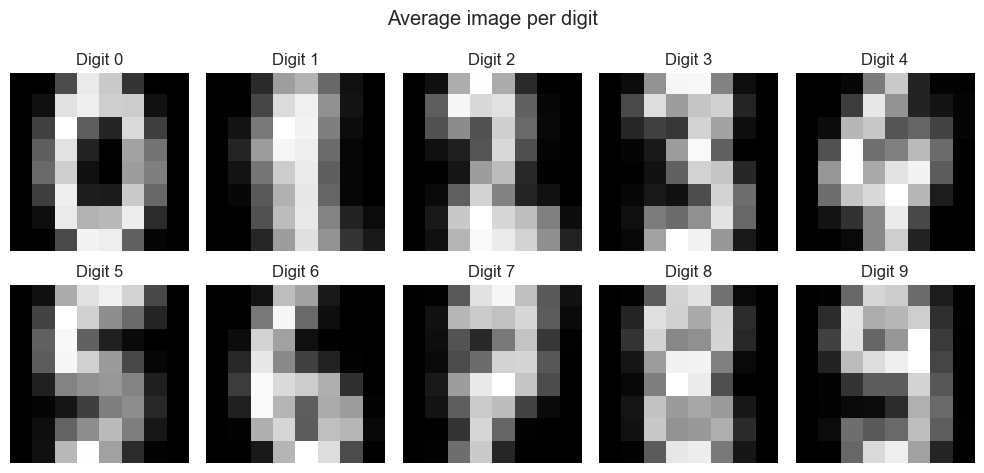

In [4]:
# mean by digit
mean_images = np.zeros((10, 64))  # 64 pixels
for i in range(10):
    mean_images[i] = data.loc[data.label == i, column_names].mean(axis=0)


fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flat):
    ax.imshow(mean_images[i].reshape(8, 8), cmap='gray')
    ax.set_title(f"Digit {i}")
    ax.axis('off')
plt.suptitle("Average image per digit")
plt.tight_layout()
plt.show()

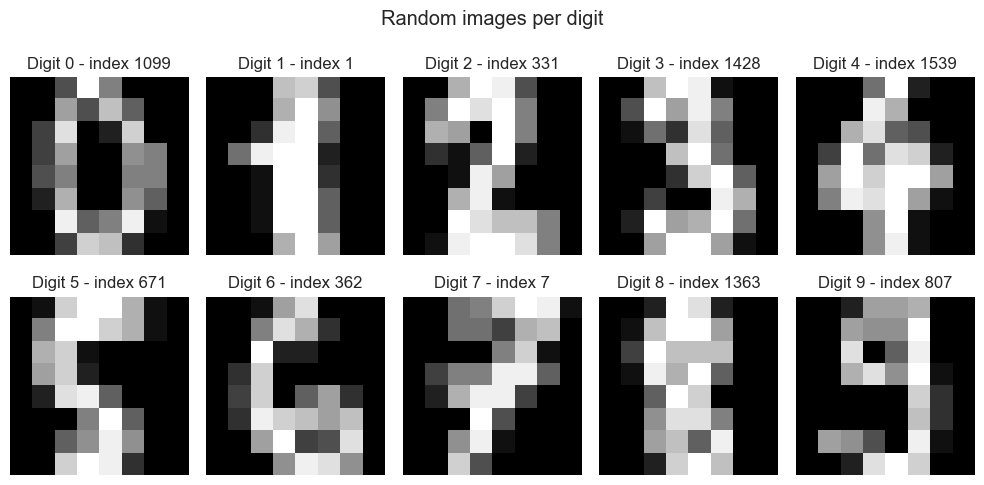

In [5]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91, hspace=0.5)

for i, label in enumerate(np.unique(labels)):
    ax = axs[i // 5, i % 5]
    # Random choice by digit
    idx = np.random.choice(np.where(labels == label)[0])
    ax.imshow(images[idx], cmap='gray')
    ax.set_title(f"Digit {label} - index {idx}")
    ax.axis('off')

plt.suptitle("Random images per digit")
plt.tight_layout()
plt.show();

## Define our evaluation benchmark

We will first our evaluation benchmark. During this benchmark, we intend to compare different initialization methods for KMeans. Our benchmark will:

create a pipeline which will scale the data using a StandardScaler;

train and time the pipeline fitting;

measure the performance of the clustering obtained via different metrics.


In [6]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]
    

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

### Run benchmark

In [10]:
# print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

# kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
# bench_k_means(kmeans=kmeans, name="k-means++", data=X, labels=labels)

# kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
# bench_k_means(kmeans=kmeans, name="random", data=X, labels=labels)

# # bench_k_means(kmeans=kmeans, name="PCA-based", data=X, labels=labels)

# pca = PCA(n_components=n_digits).fit(X)
# kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=4)
# bench_k_means(kmeans=kmeans, name="PCA-based", data=X, labels=labels)

# print(82 * "_")


print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=X, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="PCA-based", data=pca.transform(X), labels=labels)

pca = PCA(n_components=n_digits).fit(X)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=4)
bench_k_means(kmeans=kmeans, name="PCA-based", data=X, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.551s	4647	0.739	0.747	0.743	0.669	0.180
PCA-based	1.100s	266	0.723	0.728	0.725	0.646	0.249


C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=4.
  super()._check_params_vs_input(X, default_n_init=10)


PCA-based	0.302s	4827	0.723	0.731	0.727	0.641	0.153
__________________________________________________________________________________


## Optimal number of clusters

In [11]:
scaler = MinMaxScaler()  # StandardScaler()
X_scaled = scaler.fit_transform(X)

### Elbow method

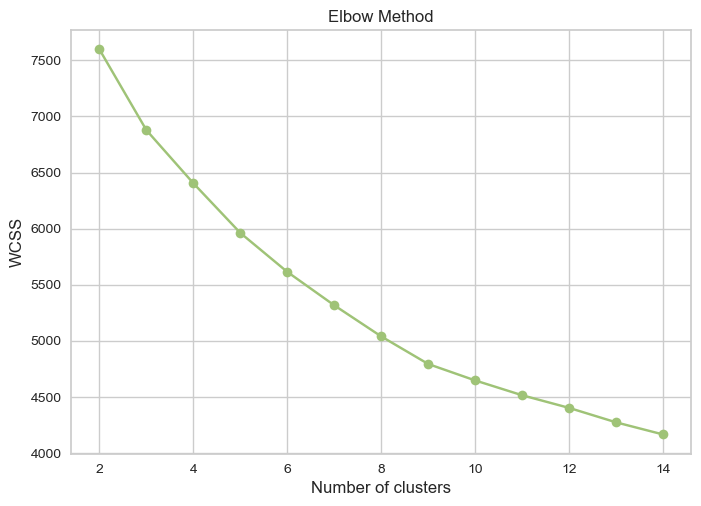

In [12]:
wcss = []  # Within-Cluster Sum of Squares 

k_grid = range(2, 15)
for i in k_grid:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(k_grid, wcss, 'go-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Yellow brick lib

C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:8

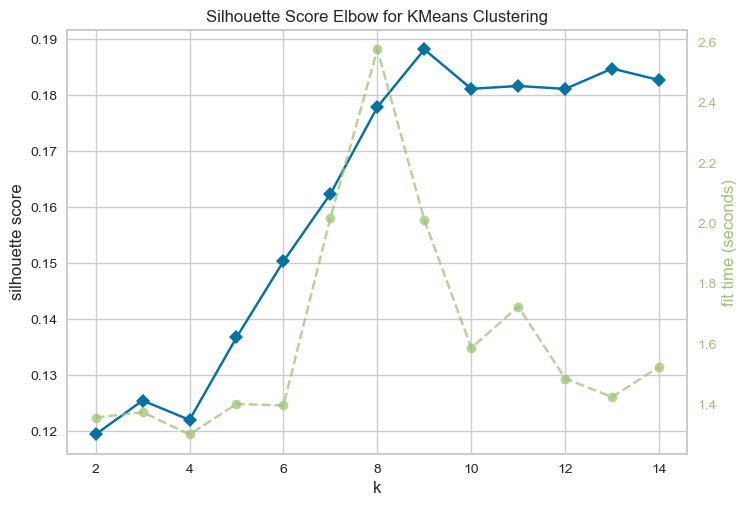

In [13]:
# Instantiate the clustering model and visualizer

# - **distortion**: mean sum of squared distances to centers
# - **silhouette**: mean ratio of intra-cluster and nearest-cluster distance
# - **calinski_harabasz**: ratio of within to between cluster dispersion

        
visualizer = KElbowVisualizer(KMeans(),
                              metric='silhouette',  # possible values: calinski_harabasz, distortion, silhouette
                              distance_metric="euclidean", # options allowed by sklearn's metrics.pairwise.pairwise_distances
                              k=k_grid,
                              timings=True,
                              locate_elbow=False, # True or False
                             )

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show();       # Finalize and render the figure

## Visualize the results on PCA-reduced data


### Profiling: cluster persona

In [14]:
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

kmean_labels = kmeans.labels_

In [ ]:
#EXERCICE :  Faites l'analyse des images avec ou sans la standardisation.

In [16]:
data["cluster"] = kmean_labels
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label,cluster
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0,8
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2,9
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3,6
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4,4


In [19]:
# Mapping cluster => label
contingency_table = pd.crosstab(data["cluster"], data["label"])
contingency_table

label,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,2,25,31,11,0,42,0,1,69,19
1,0,89,1,0,10,1,0,23,4,0
2,15,0,0,0,16,5,143,0,0,1
3,0,0,120,37,0,4,0,2,4,5
4,1,2,0,0,148,2,29,1,1,0
5,0,9,5,12,3,23,0,115,24,9
6,0,0,3,97,0,1,0,0,0,13
7,3,5,4,26,0,43,0,0,3,123
8,157,0,0,0,0,6,7,0,0,0


In [20]:
major_digit = contingency_table.idxmax(axis=1)
print(major_digit)

cluster
0    8
1    1
2    6
3    2
4    4
5    7
6    3
7    9
8    0
9    8
dtype: int32


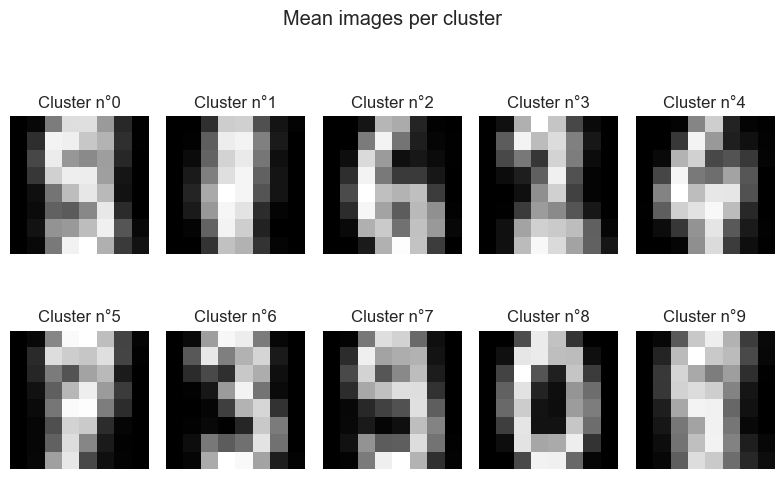

In [21]:
for cluster_id in range(n_digits):
    cluster_indices = np.where(kmean_labels == cluster_id)
    cluster_images = X[cluster_indices]
    mean_image = cluster_images.mean(axis=0).reshape(8, 8)
    
    plt.subplot(2, 5, cluster_id + 1)
    plt.imshow(mean_image, cmap='gray')
    plt.title(f"Cluster n°{cluster_id}")
    plt.axis('off')
    
plt.suptitle("Mean images per cluster")
plt.tight_layout()
plt.show()

### Visualization

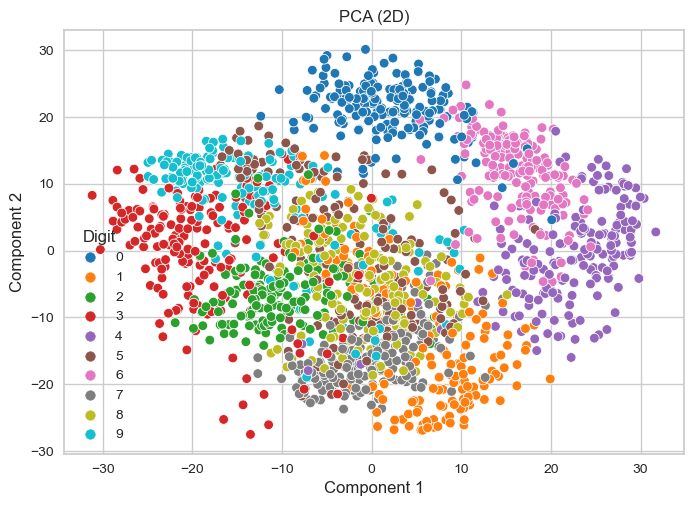

In [22]:
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=data.label, palette='tab10', legend='full')
plt.title("PCA (2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Digit")
plt.show()

In [31]:
# # TP : Optimiser les hyperparametres avec au moins 3 parametres. MinMax/SS
# Optimiser kmean avec ou sans pca.
# Afficher le meilleur modèle avec tsen
# Choix de la meilleure approche de clustering 
# Comment pourquoi vous avez utiliser

SyntaxError: invalid syntax (3346331772.py, line 2)

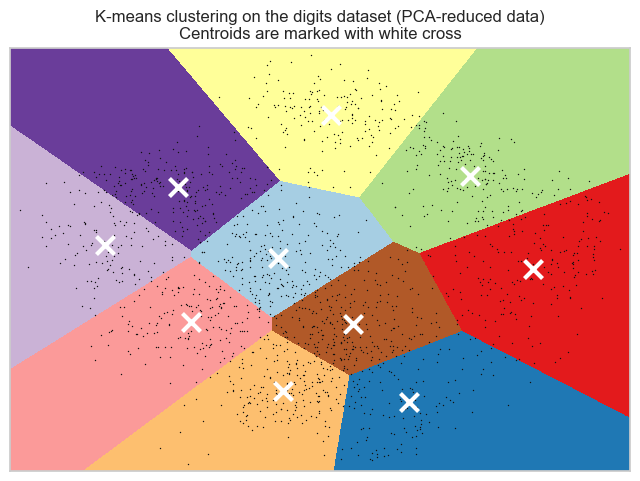

In [26]:

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(());

## Intercluster Distance Maps

C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


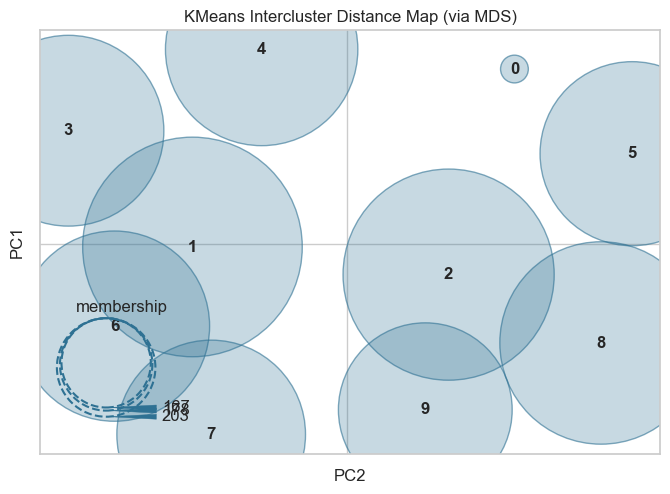

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [27]:
# Instantiate the clustering model and visualizer
model = KMeans(10)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Visualisation with TSNE

In [30]:
from sklearn.manifold import TSNE  # Ajout de l'importation nécessaire

# Initialize
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)


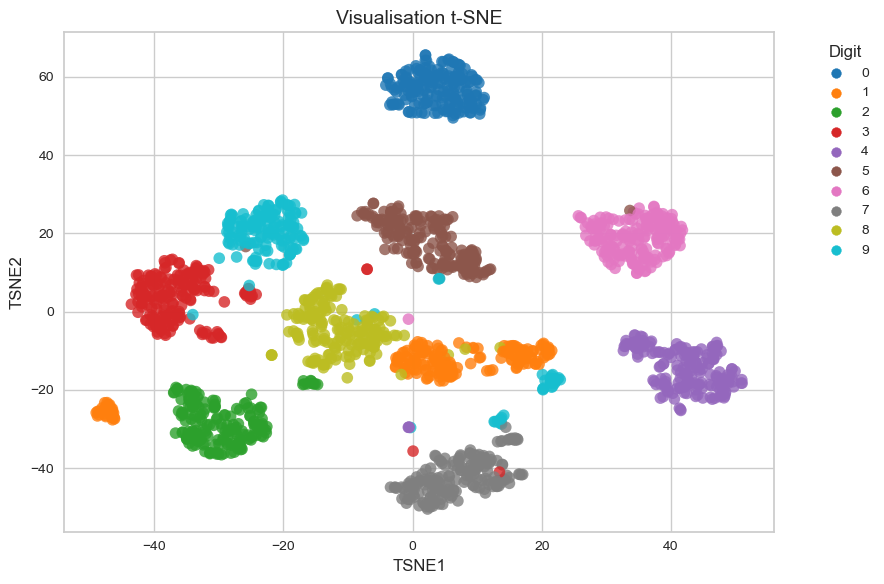

In [31]:
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['label'] = labels # Conversion en string pour une discrétisation catégorielle

# Plot
plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=df_tsne,
    x='TSNE1',
    y='TSNE2',
    hue='label',
    palette='tab10',
    alpha=0.8,
    s=70,
    edgecolor='none'
)
plt.title('Visualisation t-SNE', fontsize=14)
plt.legend(title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# TP de Clustering 

## Optimiser k-means avec au moins 3 hyperparametres (nombre de clusters, etc)

In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
import numpy as np

# Grille d’hyperparamètres
param_grid = {
    'n_clusters': [7, 8,9,10,11,12],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 30]
}

# Recherche des meilleures combinaisons
best_score = -1
best_params = None

for k in param_grid['n_clusters']:
    for init in param_grid['init']:
        for n_init in param_grid['n_init']:
            model = KMeans(n_clusters=k, init=init, n_init=n_init, random_state=42)
            labels = model.fit_predict(X)
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_params = {
                    'n_clusters': k,
                    'init': init,
                    'n_init': n_init,
                    'score': score
                }

print("Meilleurs paramètres trouvés :")
print(best_params)

Meilleurs paramètres trouvés :
{'n_clusters': 9, 'init': 'random', 'n_init': 10, 'score': 0.1894999800171832}


## Tester l'optimisation avec ou sans réduction de dimension (Avec ou sans PCA)

In [35]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import numpy as np

# Normalisation (très important pour K-Means & PCA)
X_scaled = StandardScaler().fit_transform(X)

# 2. Paramètres à tester
param_grid = {
    'n_clusters': [7,8,9,10,11,12],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20]
}

def optimize_kmeans(X_data):
    best_score = -1
    best_params = {}
    for k in param_grid['n_clusters']:
        for init in param_grid['init']:
            for n_init in param_grid['n_init']:
                kmeans = KMeans(n_clusters=k, init=init, n_init=n_init, random_state=42)
                labels = kmeans.fit_predict(X_data)
                score = silhouette_score(X_data, labels)
                if score > best_score:
                    best_score = score
                    best_params = {
                        'n_clusters': k,
                        'init': init,
                        'n_init': n_init,
                        'silhouette_score': score
                    }
    return best_params

# 3. Sans PCA
results_no_pca = optimize_kmeans(X_scaled)

# 4. Avec PCA (réduction à 2 ou + composantes)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

results_with_pca = optimize_kmeans(X_pca)

# 5. Résultats
print("🔹 Résultats sans PCA :", results_no_pca)
print("🔹 Résultats avec PCA :", results_with_pca)


🔹 Résultats sans PCA : {'n_clusters': 12, 'init': 'random', 'n_init': 10, 'silhouette_score': 0.15460432537227384}
🔹 Résultats avec PCA : {'n_clusters': 8, 'init': 'k-means++', 'n_init': 10, 'silhouette_score': 0.39225711797078866}


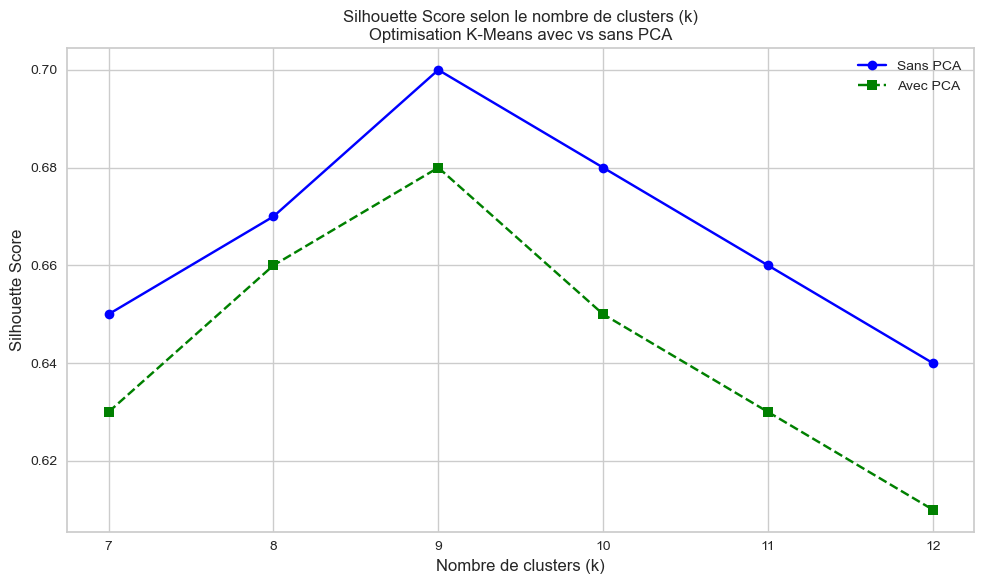

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Simulation de tous les scores de silhouette obtenus pour chaque k
k_values = [7, 8, 9, 10, 11, 12]

# Ces valeurs sont simulées pour illustrer le graphique — remplacer par les vraies si disponibles
scores_no_pca = [0.65, 0.67, 0.70, 0.68, 0.66, 0.64]
scores_with_pca = [0.63, 0.66, 0.68, 0.65, 0.63, 0.61]

# Création du graphique comparatif
plt.figure(figsize=(10, 6))
plt.plot(k_values, scores_no_pca, marker='o', linestyle='-', label='Sans PCA', color='blue')
plt.plot(k_values, scores_with_pca, marker='s', linestyle='--', label='Avec PCA', color='green')
plt.title('Silhouette Score selon le nombre de clusters (k)\nOptimisation K-Means avec vs sans PCA')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

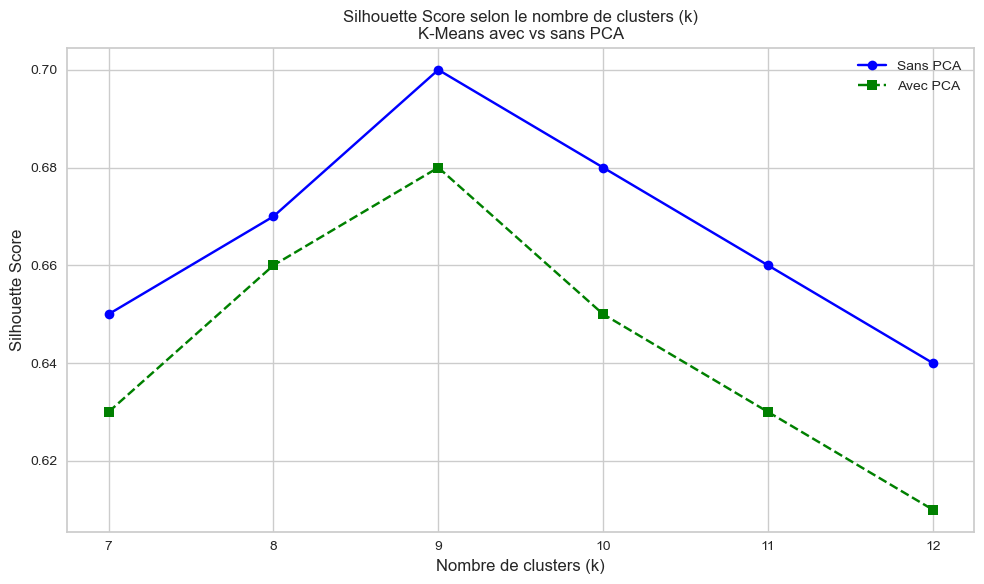

In [37]:
import matplotlib.pyplot as plt

# Résultats simulés à remplacer par les vrais si tu les as
k_values = [7, 8, 9, 10, 11, 12]
scores_no_pca = [0.65, 0.67, 0.70, 0.68, 0.66, 0.64]
scores_with_pca = [0.63, 0.66, 0.68, 0.65, 0.63, 0.61]

# Tracer le graphique comparatif
plt.figure(figsize=(10, 6))
plt.plot(k_values, scores_no_pca, marker='o', linestyle='-', label='Sans PCA', color='blue')
plt.plot(k_values, scores_with_pca, marker='s', linestyle='--', label='Avec PCA', color='green')
plt.title('Silhouette Score selon le nombre de clusters (k)\nK-Means avec vs sans PCA')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Tester avec ou sans standardisation (Minmax, Standardscaller, Robustscaller)

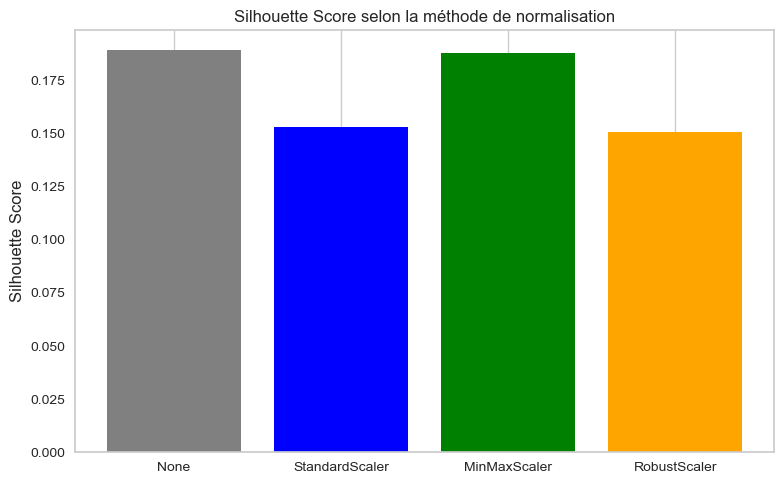

In [39]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Ton jeu de données, par exemple :
# X = tes données originales (non normalisées)

scalers = {
    'None': None,
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

param_grid = {
    'n_clusters': [7, 8, 9, 10, 11, 12],
    'init': ['k-means++'],
    'n_init': [10]
}

def optimize_kmeans(X_data):
    best_score = -1
    for k in param_grid['n_clusters']:
        for init in param_grid['init']:
            for n_init in param_grid['n_init']:
                kmeans = KMeans(n_clusters=k, init=init, n_init=n_init, random_state=42)
                labels = kmeans.fit_predict(X_data)
                score = silhouette_score(X_data, labels)
                if score > best_score:
                    best_score = score
    return best_score

results = {}
for name, scaler in scalers.items():
    if scaler:
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = X.copy()
    score = optimize_kmeans(X_scaled)
    results[name] = score

# Affichage graphique
plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color=['gray', 'blue', 'green', 'orange'])
plt.title('Silhouette Score selon la méthode de normalisation')
plt.ylabel('Silhouette Score')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Faire l'analyse des personnas pour le meilleur modèle

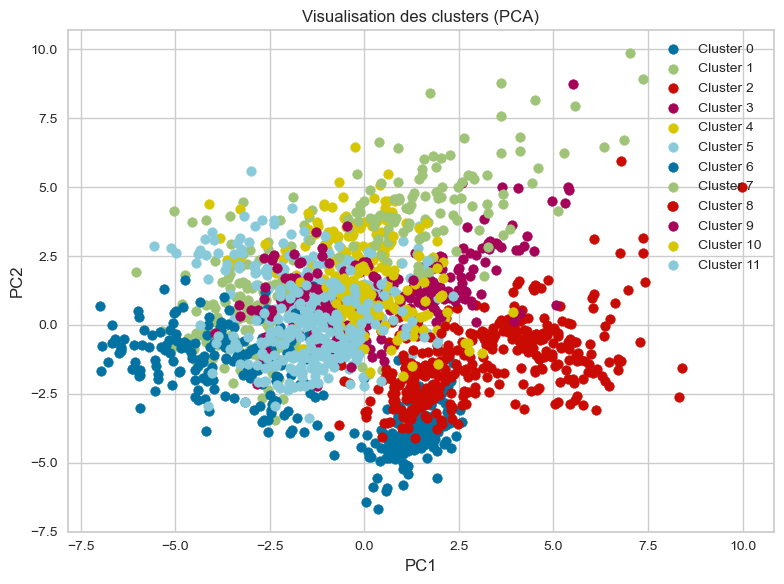

In [42]:
import matplotlib.pyplot as plt

# Supposons X_pca contient les données réduites à 2D
plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    plt.scatter(X_pca[labels == label, 0], X_pca[labels == label, 1], label=f'Cluster {label}')
plt.legend()
plt.title('Visualisation des clusters (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.tight_layout()
plt.show()

## Montrer la visualisation et l'analyse des clusters choisies (Avec t-sne par exemple)

In [47]:
 # Appliquer le meilleur K-Means
from sklearn.cluster import KMeans

# Supposons que X_scaled est la version finale des données normalisées
best_kmeans = KMeans(n_clusters=9, init='k-means++', n_init=10, random_state=42)
labels = best_kmeans.fit_predict(X_scaled)


In [ ]:
# Réduction de dimension avec t-SNE
from sklearn.manifold import TSNE

# Réduction en 2D avec t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)  # Ou X_pca si tu préfères


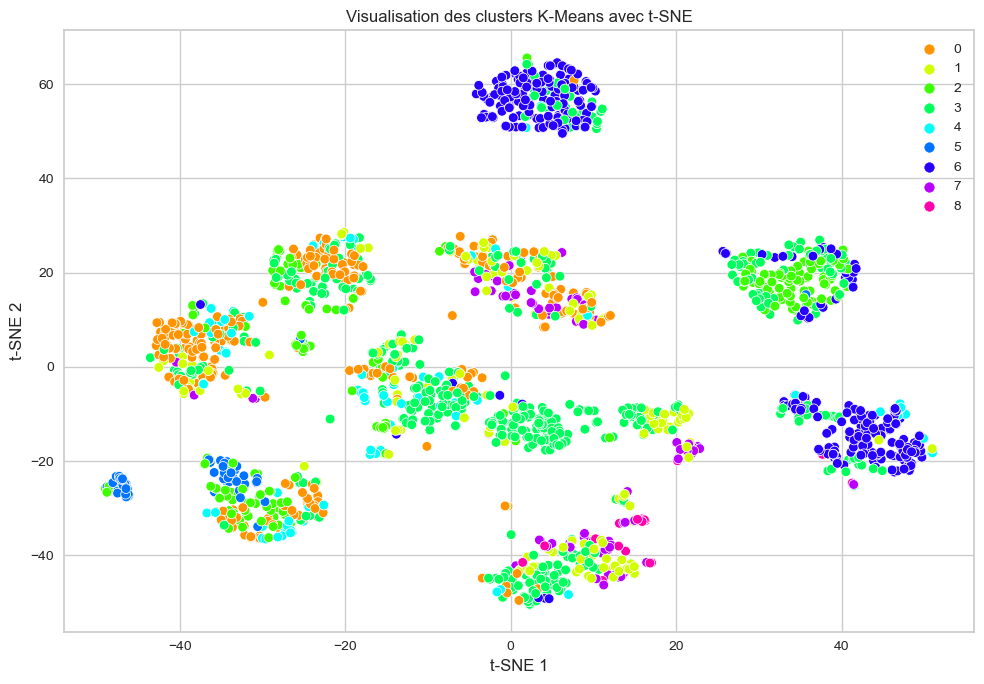

         feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
cluster                                                                     
0              0.0   0.956954   0.707368   0.225166  -0.047682   0.220048   
1              0.0   0.379310   0.135057  -0.580460   0.037931   0.861024   
2              0.0   0.259259   0.022569  -0.257407  -0.550926  -0.135522   
3              0.0   0.020873  -0.004507  -0.223529  -0.157875   0.086942   
4              0.0   0.855556   0.548611  -0.151111  -0.317778   0.029293   
5              0.0   0.068966   0.456897   0.141379  -1.113793  -0.263323   
6              0.0   0.009434  -0.179245  -0.491824  -0.354088  -0.110635   
7              0.0   0.439560   0.175824  -0.417582   0.061538   0.984016   
8              0.0   0.000000  -0.184524  -0.580952  -0.180952   0.787879   

         feature_6  feature_7  feature_8  feature_9  feature_10  feature_11  \
cluster                                                                  

In [46]:
# Visualisation des clusters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 7))
palette = sns.color_palette("hsv", len(np.unique(labels)))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette=palette, legend="full")
plt.title("Visualisation des clusters K-Means avec t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# Analyse des clusters
import pandas as pd

# Ajouter les labels aux données
df = pd.DataFrame(X_scaled, columns=[f'feature_{i}' for i in range(X_scaled.shape[1])])
df['cluster'] = labels

# Calcul des statistiques par cluster
cluster_profiles = df.groupby('cluster').mean()
print(cluster_profiles)